![oops couldn't find image](Data-Science-Essentials-2020-header.png)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import geopandas as gpd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from cm import plot_confusion_matrix

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

## Week 6

## Use random forest classifier to predict healthcare cost burden for cancer and heart attacks (i.e. avg_cost/avg_income ratio)

## 1. Load and clean the original healthcare cost and income data

In [2]:
# 1a. Load/clean the heart attack and cancer costs data
state_abbr = pd.read_csv('../data/state_abbrev.csv')
ha_costs_df = pd.read_csv('../data/mmd_heart_attack_data.csv')
cancer_costs_df = pd.read_csv('../data/mmd_cancer_data.csv')

# Rename analysis_value column for cost data
ha_costs_df = ha_costs_df.rename(columns = {'analysis_value': 'ha_avg_cost'})
cancer_costs_df = cancer_costs_df.rename(columns = {'analysis_value': 'cancer_avg_cost'})

# Merge the two costs datasets
costs_df = pd.merge(left=cancer_costs_df[['state','county','urban','cancer_avg_cost']], 
                    right=ha_costs_df[['state','county','ha_avg_cost']], 
                    left_on=['state','county'], right_on=['state','county'], how='outer')

# Remove those rows which don't contain "County" in the name
costs_df = costs_df[costs_df['county'].str.contains('County')]

# Change state names to abbrevition (as it is in income data)
state_dict = state_abbr.set_index('name').T.to_dict('list')
costs_df.state = costs_df.state.replace(state_dict)  

# 1b. Load/clean the income data
# Read in income data and change some column names
income_df = pd.read_csv('../data/irs_county_2016.csv')
keep_cols = ['STATE', 'COUNTYNAME', 'agi_stub', 'N1', 'mars1', 'MARS2', 'MARS4', 'N2', 'NUMDEP', 'ELDERLY', 'A00100', 'N02650', 'A02650', 'N02300', 'A02300']
income_df = income_df.loc[:,keep_cols]
income_df.columns = ['state', 'county', 'income_bucket', 'return_count', 'single_returns', 'joint_returns', 'head_of_house_returns', 'exemptions', 'dependents', 'elderly', 'agi', 'returns_with_total_inc','total_inc_amt', 'returns_with_unemployment', 'unemployment_comp']

# Aggregate income data by county
income_county_df = income_df.groupby(['state', 'county']).sum().reset_index()

# Create new average income column
income_county_df['avg_inc'] = 1000 * income_county_df.total_inc_amt/income_county_df.return_count

# Create reduced version of income data
income_sub = income_county_df[['state','county', 'avg_inc','elderly','dependents','returns_with_unemployment']]

# Remove those rows which don't contain "County" in the name
income_sub = income_sub[income_sub['county'].str.contains('County')].reset_index()
income_sub

,index,state,county,avg_inc,elderly,dependents,returns_with_unemployment
0,31,AL,Autauga County,55680.240764,5340,17390,430
1,32,AL,Baldwin County,62603.044838,29090,57200,1980
2,33,AL,Barbour County,40094.136808,2400,6970,260
3,34,AL,Bibb County,47260.201511,1670,6120,290
4,35,AL,Blount County,49333.197648,5350,16330,540
...,...,...,...,...,...,...,...
2987,3185,WY,Sweetwater County,67995.656617,4310,14380,1200
2988,3186,WY,Teton County,214588.045007,3120,7870,720
2989,3187,WY,Uinta County,60912.403101,2280,7260,520
2990,3188,WY,Washakie County,62248.501362,1220,2260,190


## 2. Load additional data from the County Health Rankings spreadsheets

### Sheet 1 - Outcomes & Factors Rankings

In [3]:
hranks = pd.read_excel('../data/2018 County Health Rankings Data - v2.xls', sheet_name = 1, header = [0,1])
# First, combine the two column name levels
col_names = [' '.join(col).strip() for col in hranks.columns.values]
# Then get rid of the "Unnamed" portion for the first 4 columns
col_names[0:4] = ['FIPS', 'State', 'County', '# of Ranked Counties']
hranks.columns = col_names
# Convert state column to abbreviation
hranks['State']=hranks.State.str.upper().map(state_abbr.set_index('name')['abbrev'].to_dict())

hranks.head(-1)

,FIPS,State,County,# of Ranked Counties,Health Outcomes Rank,Health Outcomes Quartile,Health Factors Rank,Health Factors Quartile
0,1001,AL,Autauga,67,11,1,8,1
1,1003,AL,Baldwin,67,3,1,3,1
2,1005,AL,Barbour,67,34,2,56,4
3,1007,AL,Bibb,67,41,3,37,3
4,1009,AL,Blount,67,14,1,19,2
...,...,...,...,...,...,...,...,...
3136,56035,WY,Sublette,23,2,1,7,2
3137,56037,WY,Sweetwater,23,15,3,21,4
3138,56039,WY,Teton,23,1,1,1,1
3139,56041,WY,Uinta,23,21,4,17,3


### Sheet 2 - Outcomes & Factors SubRankings

In [4]:
hranks2 = pd.read_excel('../data/2018 County Health Rankings Data - v2.xls', sheet_name = 2, header = [0,1])
# First, combine the two column name levels
col_names = [' '.join(col).strip() for col in hranks2.columns.values]
# Then get rid of the "Unnamed" portion for the first 4 columns
col_names[0:4] = ['FIPS', 'State', 'County', '# of Ranked Counties']
hranks2.columns = col_names
# Convert state column to abbreviation
hranks2['State']=hranks2.State.str.upper().map(state_abbr.set_index('name')['abbrev'].to_dict())

hranks2.head(-1)

,FIPS,State,County,# of Ranked Counties,Length of Life Rank,Length of Life Quartile,Quality of Life Rank,Quality of Life Quartile,Health Behaviors Rank,Health Behaviors Quartile,Clinical Care Rank,Clinical Care Quartile,Social & Economic Factors Rank,Social & Economic Factors Quartile,Physical Environment Rank,Physical Environment Quartile
0,1001,AL,Autauga,67,18,2,5,1,12,1,15,1,3,1,51,4
1,1003,AL,Baldwin,67,4,1,4,1,3,1,7,1,8,1,14,1
2,1005,AL,Barbour,67,14,1,49,3,57,4,20,2,58,4,16,1
3,1007,AL,Bibb,67,53,4,25,2,39,3,42,3,42,3,29,2
4,1009,AL,Blount,67,17,1,12,1,11,1,41,3,13,1,54,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,56035,WY,Sublette,23,2,1,4,1,5,1,9,2,8,2,17,3
3137,56037,WY,Sweetwater,23,6,1,18,4,20,4,11,2,20,4,19,4
3138,56039,WY,Teton,23,1,1,2,1,1,1,1,1,1,1,15,3
3139,56041,WY,Uinta,23,18,4,21,4,19,4,6,1,17,3,13,3


### Sheet 3 - Ranked Measure Data

In [5]:
hranks3 = pd.read_excel('../data/2018 County Health Rankings Data - v2.xls', sheet_name = 3, header = [0,1])
# First, combine the two column name levels
col_names = [' '.join(col).strip() for col in hranks3.columns.values]
# Then get rid of the "Unnamed" portion for the first 3 columns
col_names[0:3] = ['FIPS', 'State', 'County']
hranks3.columns = col_names
# Convert state column to abbreviation
hranks3['State']=hranks3.State.str.upper().map(state_abbr.set_index('name')['abbrev'].to_dict())

hranks3.head(-1)

,FIPS,State,County,Premature death Years of Potential Life Lost Rate,Premature death 95% CI - Low,Premature death 95% CI - High,Premature death Quartile,Premature death Years of Potential Life Lost Rate (Black),Premature death Years of Potential Life Lost Rate (Hispanic),Premature death Years of Potential Life Lost Rate (White),...,Driving alone to work 95% CI - High,Driving alone to work Quartile,Driving alone to work % Drive Alone (Black),Driving alone to work % Drive Alone (Hispanic),Driving alone to work % Drive Alone (White),Long commute - driving alone # Workers who Drive Alone,Long commute - driving alone % Long Commute - Drives Alone,Long commute - driving alone 95% CI - Low,Long commute - driving alone 95% CI - High,Long commute - driving alone Quartile
0,1001.0,AL,Autauga,9409.294766,8492.111635,10326.477898,2,11806.223285,NaN,9148.381743,...,88.431482,4,82.494851,NaN,82.539683,21082.0,40.8,36.698437,44.901563,3
1,1003.0,AL,Baldwin,7467.596664,7025.900408,7909.292920,1,10335.702691,2827.348216,7484.117065,...,86.017804,2,85.567010,68.864800,84.646255,73058.0,40.1,37.614952,42.585048,3
2,1005.0,AL,Barbour,8929.474982,7633.929691,10225.020273,1,9141.333085,NaN,8896.000532,...,85.796041,1,80.341227,NaN,85.656228,7271.0,35.1,29.740946,40.459054,2
3,1007.0,AL,Bibb,11741.938889,10057.801626,13426.076153,4,11297.166352,NaN,11923.067966,...,89.905820,2,NaN,NaN,NaN,7044.0,48.8,40.894758,56.705242,4
4,1009.0,AL,Blount,9359.122343,8463.490290,10254.754396,1,NaN,5133.144570,9600.725685,...,87.622499,3,NaN,79.539642,81.580997,18384.0,60.2,55.818947,64.581053,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037.0,WY,Sweetwater,6682.397752,5848.326360,7516.469144,1,NaN,4249.103214,7169.977818,...,80.387201,3,NaN,71.180453,76.392270,17537.0,18.5,15.801336,21.198664,2
3138,56039.0,WY,Teton,3823.238218,2806.927407,4839.549029,1,NaN,NaN,NaN,...,68.571890,1,NaN,57.172131,65.065532,8984.0,11.5,7.798704,15.201296,1
3139,56041.0,WY,Uinta,8365.629795,6952.016456,9779.243135,4,NaN,NaN,NaN,...,78.929607,2,NaN,NaN,NaN,7049.0,17.6,12.927295,22.272705,2
3140,56043.0,WY,Washakie,6341.903776,5093.069491,7804.258313,1,NaN,NaN,NaN,...,81.564196,3,NaN,NaN,NaN,2783.0,9.7,5.480714,13.919286,1


### Sheet 5 - Additional Measure Data

In [6]:
hranks5 = pd.read_excel('../data/2018 County Health Rankings Data - v2.xls', sheet_name = 5, header = [0,1])
# First, combine the two column name levels
col_names = [' '.join(col).strip() for col in hranks5.columns.values]
# Then get rid of the "Unnamed" portion for the first 3 columns
col_names[0:3] = ['FIPS', 'State', 'County']
hranks5.columns = col_names
# Convert state column to abbreviation
hranks5['State']=hranks5.State.str.upper().map(state_abbr.set_index('name')['abbrev'].to_dict())

hranks5.head(-1)

,FIPS,State,County,Premature age-adjusted mortality # Deaths,Premature age-adjusted mortality Age-Adjusted Mortality,Premature age-adjusted mortality 95% CI - Low,Premature age-adjusted mortality 95% CI - High,Premature age-adjusted mortality Age-Adjusted Mortality (Black),Premature age-adjusted mortality Age-Adjusted Mortality (Hispanic),Premature age-adjusted mortality Age-Adjusted Mortality (White),...,Demographics % Hispanic,Demographics # Non-Hispanic White,Demographics % Non-Hispanic White,Demographics # Not Proficient in English,Demographics % Not Proficient in English,Demographics 95% CI - Low,Demographics 95% CI - High,Demographics % Female,Demographics # Rural,Demographics % Rural
0,1001,AL,Autauga,827.0,449.6,418.5,480.7,531.7,NaN,444.9,...,2.688754,41562,75.000000,432,0.832739,0.457689,1.207789,51.288437,22921.0,42.002162
1,1003,AL,Baldwin,2753.0,351.3,337.5,365.1,517.8,111.1,349.3,...,4.416411,173529,83.202198,1540,0.818809,0.508623,1.128996,51.457833,77060.0,42.279099
2,1005,AL,Barbour,418.0,433.6,390.5,476.6,477.0,NaN,394.7,...,4.213364,12061,46.450992,382,1.519370,0.790980,2.247760,46.932409,18613.0,67.789635
3,1007,AL,Bibb,408.0,529.1,476.7,581.4,630.4,NaN,526.6,...,2.499669,16850,74.415934,96,0.448137,0.000000,1.041411,46.363114,15663.0,68.352607
4,1009,AL,Blount,996.0,480.2,449.2,511.2,NaN,NaN,NaN,...,9.068695,50472,87.467073,1018,1.878506,1.332987,2.424025,50.613476,51562.0,89.951502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,56035,WY,Sublette,73.0,219.1,170.5,277.3,NaN,NaN,NaN,...,8.086805,8602,88.054049,58,0.619460,0.000000,1.737041,46.565667,10247.0,100.000000
3137,56037,WY,Sweetwater,480.0,356.5,323.9,389.0,NaN,262.4,376.8,...,16.076078,35152,79.592437,890,2.140040,1.512748,2.767333,48.178422,4782.0,10.916313
3138,56039,WY,Teton,124.0,154.2,126.2,182.2,NaN,NaN,NaN,...,15.122246,18896,81.479884,776,3.622952,2.101954,5.143949,48.402397,9887.0,46.430920
3139,56041,WY,Uinta,259.0,396.8,347.1,446.5,NaN,NaN,NaN,...,9.016512,18182,87.527078,257,1.329196,0.240454,2.417937,49.429548,9101.0,43.095937


## 3. Merge the cost, income, and health rankings data based on state and county.

In [7]:
# Merge costs and income data
cost_income_rank_df = pd.merge(left=income_sub, 
                               right=costs_df, 
                               left_on = ['state','county'], 
                               right_on =['state','county'], how = 'inner')

# Remove "County" from county names
cost_income_rank_df.county = cost_income_rank_df['county'].str.replace(' County', '', regex=True)
# Make state and county column names start with uppercase
cost_income_rank_df.rename(columns={'state':'State'}, inplace=True)
cost_income_rank_df.rename(columns={'county':'County'}, inplace=True)

# Merge rank data
cost_income_rank_df = pd.merge(left=cost_income_rank_df, 
                               right=hranks, 
                               left_on = ['State','County'], 
                               right_on =['State','County'], how = 'inner')
cost_income_rank_df = pd.merge(left=cost_income_rank_df, 
                               right=hranks2, 
                               left_on = ['State','County'], 
                               right_on =['State','County'], how = 'inner')
cost_income_rank_df = pd.merge(left=cost_income_rank_df, 
                               right=hranks3, 
                               left_on = ['State','County'], 
                               right_on =['State','County'], how = 'inner')
cost_income_rank_df = pd.merge(left=cost_income_rank_df, 
                               right=hranks5, 
                               left_on = ['State','County'], 
                               right_on =['State','County'], how = 'inner')


# Create the cost to income ratios
cost_income_rank_df['ha_cost_inc_ratio'] = cost_income_rank_df.ha_avg_cost / cost_income_rank_df.avg_inc;
cost_income_rank_df['cancer_cost_inc_ratio'] = cost_income_rank_df.cancer_avg_cost / cost_income_rank_df.avg_inc;
cost_income_rank_df.reindex()
cost_income_rank_df.head(-1)

# Replace the NR values present in the Quartile columns
cost_income_rank_df = cost_income_rank_df.replace('NR',np.nan)
cost_income_rank_df = cost_income_rank_df.apply(pd.to_numeric,errors='ignore')

## 4. Set up model inputs

In [8]:
# Change max number of rows shown by pandas
# pd.set_option('display.max_rows', 300)

# Drop the information about county and state
costs_inc_mdl = cost_income_rank_df
costs_inc_mdl = costs_inc_mdl.drop(columns = ['index','State','County']) # 'state'
costs_inc_mdl = pd.get_dummies(costs_inc_mdl, columns = ['urban'], drop_first = True)

# Create the target variable, i.e. above or below the mean cost/income ratio
costs_inc_mdl['abv_avg_ca'] = costs_inc_mdl.cancer_cost_inc_ratio > costs_inc_mdl.cancer_cost_inc_ratio.mean()
costs_inc_mdl['abv_avg_ha'] = costs_inc_mdl.ha_cost_inc_ratio > costs_inc_mdl.ha_cost_inc_ratio.mean()

# Remove columns with NaN, must include 80% of counties usable
#costs_inc_mdl = costs_inc_mdl.dropna()
limitPer = len(costs_inc_mdl) * .80
costs_inc_mdl = costs_inc_mdl.dropna(thresh=limitPer,axis=1)
costs_inc_mdl = costs_inc_mdl.dropna()
costs_inc_mdl = costs_inc_mdl.select_dtypes(include=['number','bool'])
costs_inc_mdl


,avg_inc,elderly,dependents,returns_with_unemployment,cancer_avg_cost,ha_avg_cost,FIPS_x,# of Ranked Counties_x,Health Outcomes Rank,Health Outcomes Quartile,...,Demographics 95% CI - Low,Demographics 95% CI - High,Demographics % Female,Demographics # Rural,Demographics % Rural,ha_cost_inc_ratio,cancer_cost_inc_ratio,urban_Urban,abv_avg_ca,abv_avg_ha
0,55680.240764,5340,17390,430,19293,40470.0,1001,67,11.0,1.0,...,0.457689,1.207789,51.288437,22921.0,42.002162,0.726829,0.346496,1,False,False
1,62603.044838,29090,57200,1980,17151,36615.0,1003,67,3.0,1.0,...,0.508623,1.128996,51.457833,77060.0,42.279099,0.584876,0.273964,0,False,False
2,40094.136808,2400,6970,260,19469,46509.0,1005,67,34.0,2.0,...,0.790980,2.247760,46.932409,18613.0,67.789635,1.159995,0.485582,0,True,True
3,47260.201511,1670,6120,290,17234,42949.0,1007,67,41.0,3.0,...,0.000000,1.041411,46.363114,15663.0,68.352607,0.908777,0.364662,1,False,False
4,49333.197648,5350,16330,540,20317,50067.0,1009,67,14.0,1.0,...,1.332987,2.424025,50.613476,51562.0,89.951502,1.014874,0.411832,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2955,67220.108696,5080,7140,760,19707,64836.0,56029,23,5.0,1.0,...,0.012667,1.036820,50.199298,12478.0,44.240383,0.964533,0.293171,0,False,False
2956,52024.401914,1480,2100,190,23937,47718.0,56031,23,18.0,4.0,...,0.000000,1.913595,49.009217,5083.0,58.647744,0.917223,0.460111,0,True,False
2957,68287.817938,4850,7410,770,19864,59314.0,56033,23,9.0,2.0,...,0.000000,0.817466,49.731788,10330.0,35.478775,0.868588,0.290886,0,False,False
2959,67995.656617,4310,14380,1200,23139,57980.0,56037,23,15.0,3.0,...,1.512748,2.767333,48.178422,4782.0,10.916313,0.852702,0.340301,0,False,False


## 5. Build/Train the model

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
#import graphviz
from IPython.display import SVG


### Build

In [10]:
# Set the X (predictor) and y (target) variables
X = costs_inc_mdl.drop(columns = ['avg_inc','cancer_avg_cost','ha_avg_cost','abv_avg_ha','abv_avg_ca',
                                  'ha_cost_inc_ratio','cancer_cost_inc_ratio']) #'avg_inc','ha_avg_cost'

# Drop any column that included the word "income" or "poverty", as this is highly related to our cost burden measure
X = X.loc[:,~X.columns.str.contains('income')]
X = X.loc[:,~X.columns.str.contains('Income')]
X = X.loc[:,~X.columns.str.contains('Poverty')]
X = X.loc[:,~X.columns.str.contains('poverty')]

# Remove features that aren't actionable/related to resources
searchfor = ['Health Outcomes', 'Health Factors','Length of Life','Quality of Life','Health Behaviors','Social & Economic Factors'
             'Physical Environment','Premature death','Poor or fair health','Children in poverty','mortality','Health care costs',
             'Demographics','college','Teen','teen','price']
X = X.loc[:,~X.columns.str.contains('|'.join(searchfor))]


y = costs_inc_mdl.abv_avg_ca

# Split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321, test_size = .1)

### Train Random Forest with adjusted settings

In [11]:
forest = RandomForestClassifier(n_estimators = 1000, max_depth = 7, min_samples_leaf = 10)
forest.fit(X_train, y_train)
y_pred_train = forest.predict(X_train)
print(metrics.accuracy_score(y_train, y_pred_train))
y_pred = forest.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.8917010005885815
0.8359788359788359


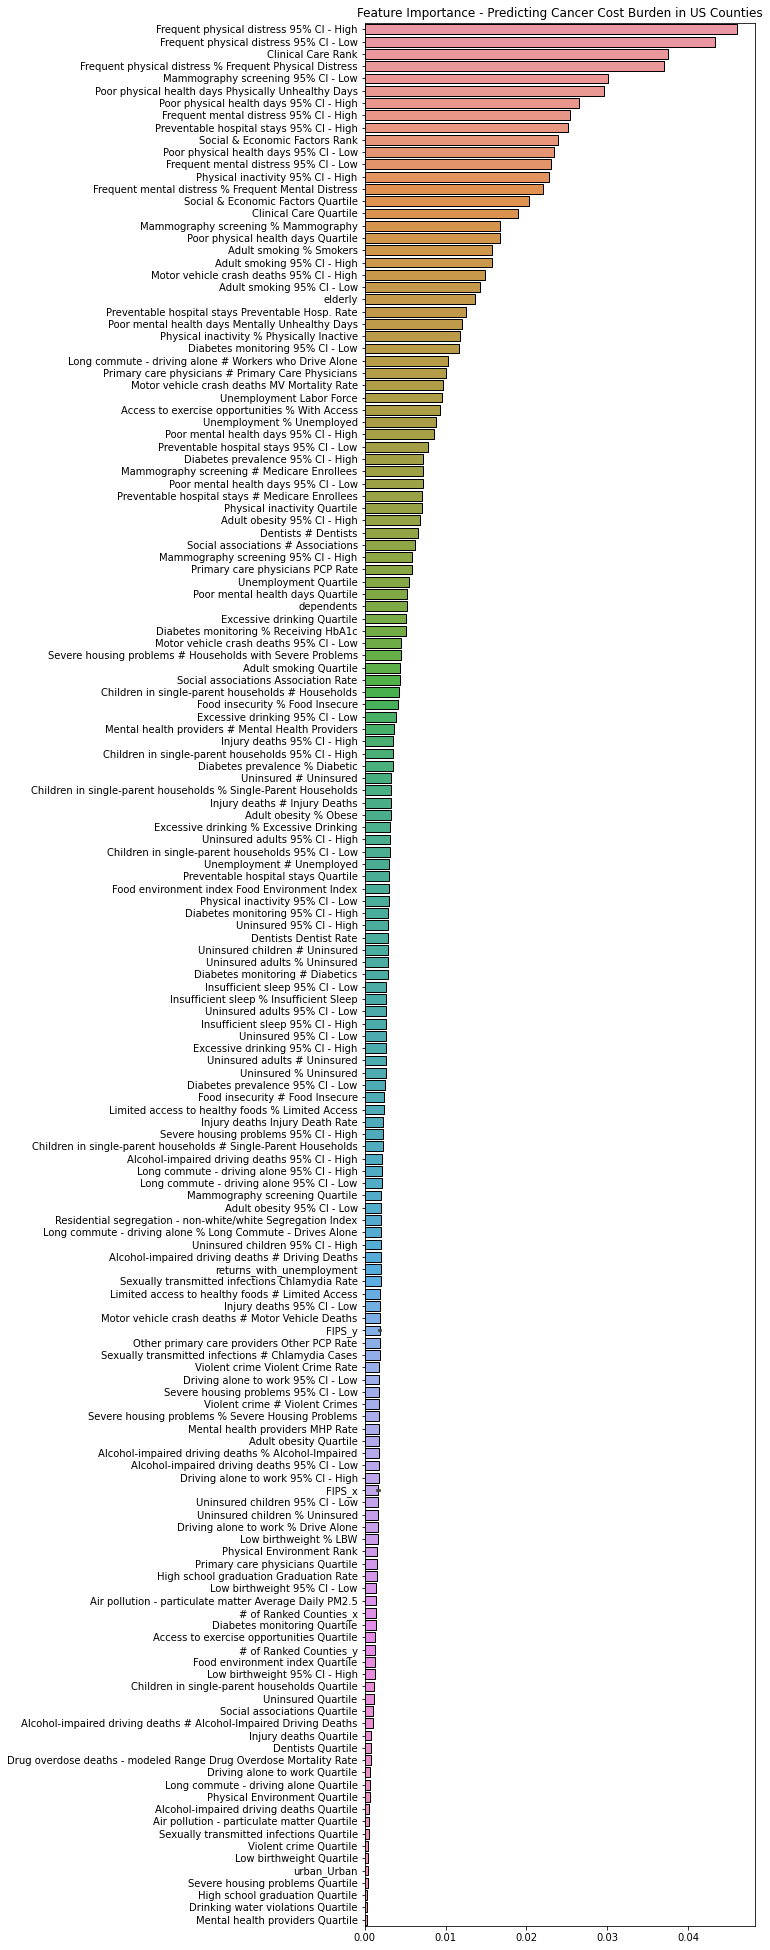

In [12]:
# Get sorted index of features based on importance (negate so the list is highest to lowest)
ind = np.argsort(-forest.feature_importances_)

# Plot bar chart of importances
fig, ax = plt.subplots(figsize = (7,35))
sns.barplot(x = forest.feature_importances_[ind], y = list(X.columns[ind]), ax = ax, edgecolor = 'black')
plt.title('Feature Importance - Predicting Cancer Cost Burden in US Counties');
plt.savefig('feature_importance_pred_cancer_cost_burden_randforest_all_feats.png')

-------
# Now build a new model but eliminate any highly correlated features. If correlated, keep the feature showing highest importance in previous model

In [13]:
# Sort the feature matrix by the index of importance from previous model
X_sorted = X.iloc[:,ind]

# Create correlation matrix
corr_matrix = X_sorted.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
X_sorted_drop = X_sorted.drop(X_sorted[to_drop], axis=1)
X_sorted_drop

,Frequent physical distress 95% CI - High,Clinical Care Rank,Mammography screening 95% CI - Low,Frequent mental distress 95% CI - High,Preventable hospital stays 95% CI - High,Social & Economic Factors Rank,Physical inactivity 95% CI - High,Social & Economic Factors Quartile,Clinical Care Quartile,Mammography screening % Mammography,...,Alcohol-impaired driving deaths Quartile,Air pollution - particulate matter Quartile,Sexually transmitted infections Quartile,Violent crime Quartile,Low birthweight Quartile,urban_Urban,Severe housing problems Quartile,High school graduation Quartile,Drinking water violations Quartile,Mental health providers Quartile
0,13.181426,15.0,55.401654,12.960696,91.09,3.0,35.9,1.0,1.0,62.693157,...,3.0,3.0,2.0,2.0,1.0,1,3.0,3.0,1.0,3.0
1,12.997419,7.0,62.560457,13.172518,49.46,8.0,27.4,1.0,1.0,65.965233,...,3.0,1.0,1.0,1.0,1.0,0,2.0,4.0,1.0,1.0
2,16.620304,20.0,54.464387,14.959202,67.85,58.0,35.5,4.0,2.0,63.030303,...,4.0,2.0,3.0,2.0,3.0,0,3.0,4.0,1.0,4.0
3,13.549926,42.0,50.427685,13.176622,108.89,42.0,43.3,3.0,3.0,61.306533,...,3.0,3.0,1.0,1.0,3.0,1,1.0,4.0,1.0,4.0
4,14.196881,41.0,52.313565,14.235685,65.42,13.0,35.0,1.0,3.0,59.584296,...,1.0,4.0,1.0,1.0,1.0,1,1.0,2.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2955,10.494335,2.0,58.180797,10.824384,46.58,6.0,26.2,1.0,1.0,65.217391,...,2.0,1.0,2.0,4.0,2.0,0,1.0,2.0,1.0,2.0
2956,11.200118,18.0,42.903649,11.587688,68.39,21.0,30.2,4.0,4.0,54.487179,...,1.0,1.0,1.0,3.0,2.0,0,1.0,2.0,1.0,3.0
2957,10.596674,3.0,50.918431,11.102178,35.95,5.0,24.0,1.0,1.0,58.438287,...,4.0,4.0,3.0,1.0,1.0,0,4.0,1.0,3.0,1.0
2959,10.893118,11.0,54.155173,10.977679,55.92,20.0,29.5,4.0,2.0,62.133333,...,4.0,4.0,2.0,4.0,3.0,0,2.0,3.0,3.0,2.0


In [14]:
# Set the X (predictor) and y (target) variables
# BUT Drop confidence interval information to simplify potential interpretations
X2 = X_sorted_drop
y2 = costs_inc_mdl.abv_avg_ca

# Split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X2, y2, random_state = 8, test_size = 0.1)

In [15]:
# TRAIN
forest2 = RandomForestClassifier(n_estimators = 1000, max_depth = 10, min_samples_leaf = 10)
forest2.fit(X_train, y_train)
y_pred_train = forest2.predict(X_train)
print(metrics.accuracy_score(y_train, y_pred_train))
y_pred = forest2.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.9064155385520895
0.8359788359788359


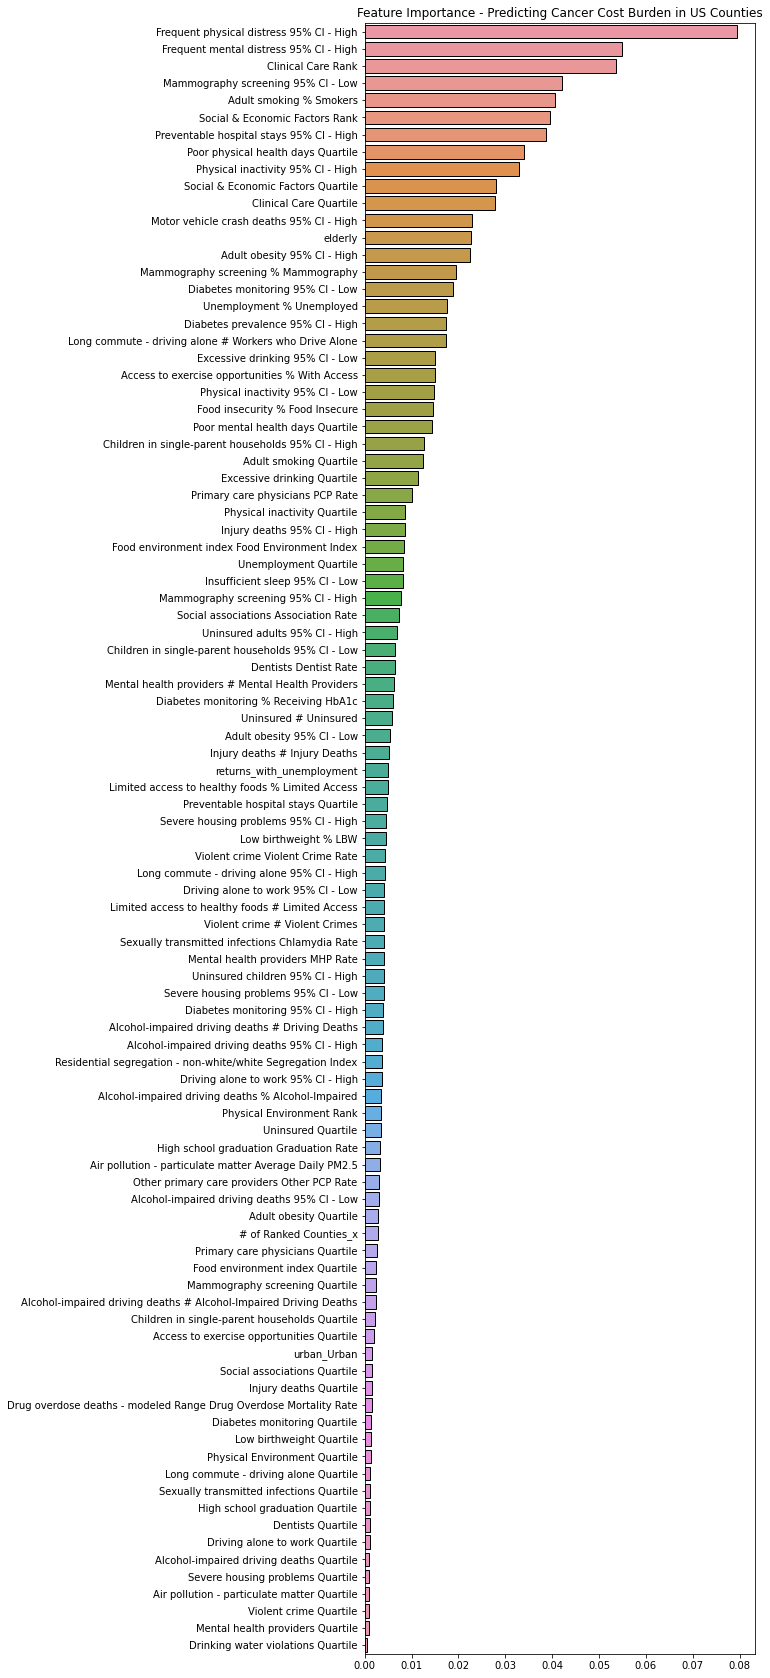

In [16]:
# PLOT
# Get sorted index of features based on importance (negate so the list is highest to lowest)
ind = np.argsort(-forest2.feature_importances_)

# Plot bar chart of importances
fig, ax = plt.subplots(figsize = (7,30))
sns.barplot(x = forest2.feature_importances_[ind], y = list(X2.columns[ind]), ax = ax, edgecolor = 'black')
plt.title('Feature Importance - Predicting Cancer Cost Burden in US Counties');
plt.savefig('feature_importance_pred_cancer_cost_burden_randforest_uncorr_feats.png')

-------
# Now build a new model but with only the top 20% of features of previous model, based on importance

In [17]:
# Set indices to keep, i.e. the top 1/3 of all features in terms of importance
feats2keep = ind[0:round(len(ind)*.333)]

# Set the X (predictor) and y (target) variables
X3 = X2.iloc[:,feats2keep]
y3 = costs_inc_mdl.abv_avg_ca

# Split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X3, y3, random_state = 9, test_size = 0.1)

In [18]:
# TRAIN
forest3 = RandomForestClassifier(n_estimators = 1000, max_depth = 10, min_samples_leaf = 10)
forest3.fit(X_train, y_train)
y_pred_train = forest3.predict(X_train)
print(metrics.accuracy_score(y_train, y_pred_train))
y_pred = forest3.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.8887580929958799
0.8465608465608465


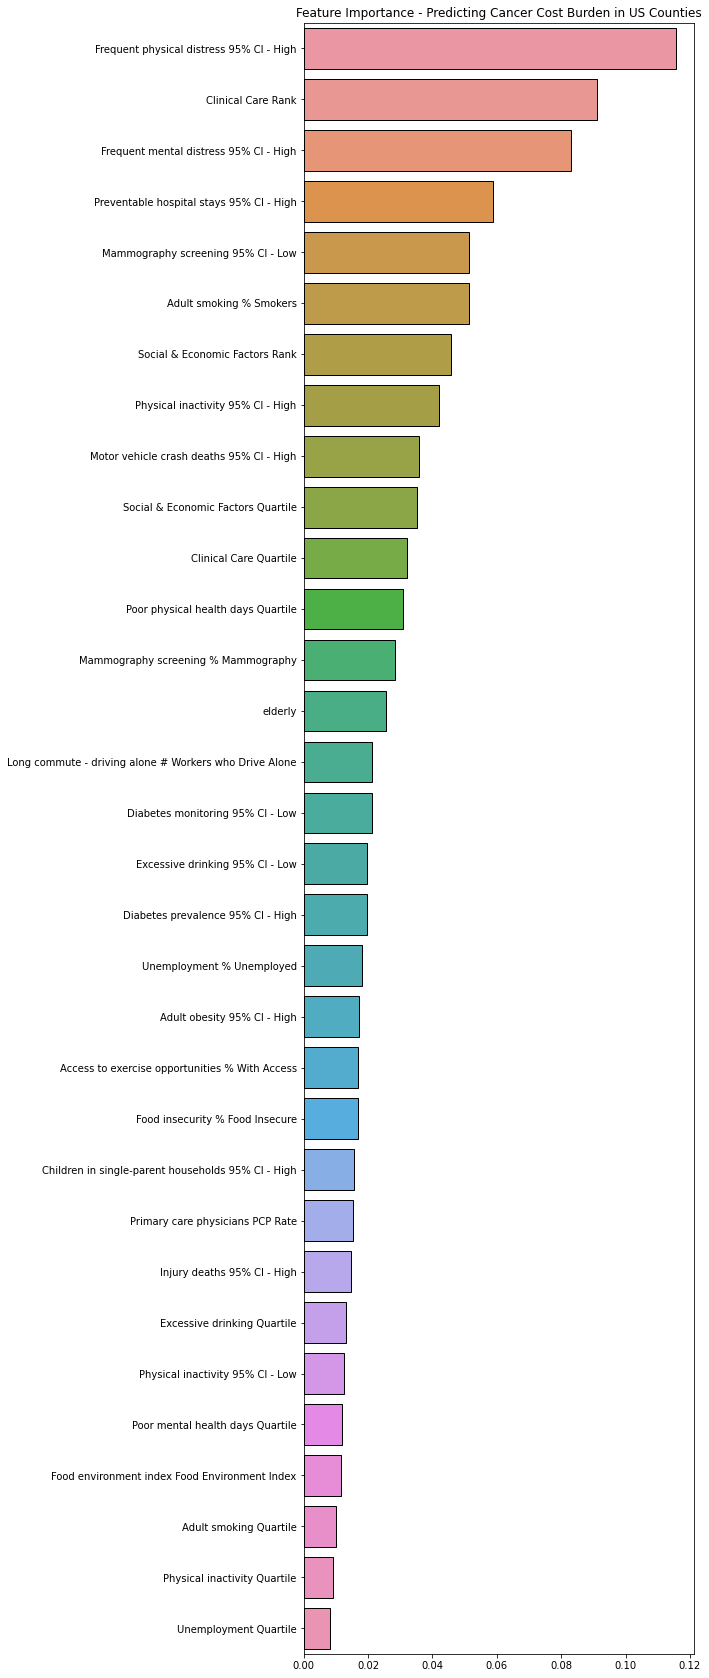

In [19]:
# PLOT
# Get sorted index of features based on importance (negate so the list is highest to lowest)
ind = np.argsort(-forest3.feature_importances_)

# Plot bar chart of importances
fig, ax = plt.subplots(figsize = (7,30))
sns.barplot(x = forest3.feature_importances_[ind], y = list(X3.columns[ind]), ax = ax, edgecolor = 'black')
plt.title('Feature Importance - Predicting Cancer Cost Burden in US Counties');
plt.savefig('feature_importance_pred_cancer_cost_burden_randforest_top3rd.png')


---------------

# Let's try a similar model, but using Random Forest for *regression* instead of binary classification, to predict the actual cost/income ratio score

In [20]:
from sklearn.ensemble import RandomForestRegressor
# Set the X (predictor) and y (target) variables
X4 = X3;

y_rforest = costs_inc_mdl.cancer_cost_inc_ratio   #abv_avg_ca

# Split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X4, y_rforest, random_state = 321, test_size = 0.1)

forest_reg =  RandomForestRegressor(n_estimators = 1000, max_depth = 10, min_samples_leaf = 10)
forest_reg.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, min_samples_leaf=10, n_estimators=1000)

## Check the R-squared of the model and plot the feature importance

R-squared (training set) =  0.8103708513666242
MSE (training set) =  0.002012998333920319
R-squared (testing set) =  0.6501655744586242
MSE (testing set) =  0.003182542299668272


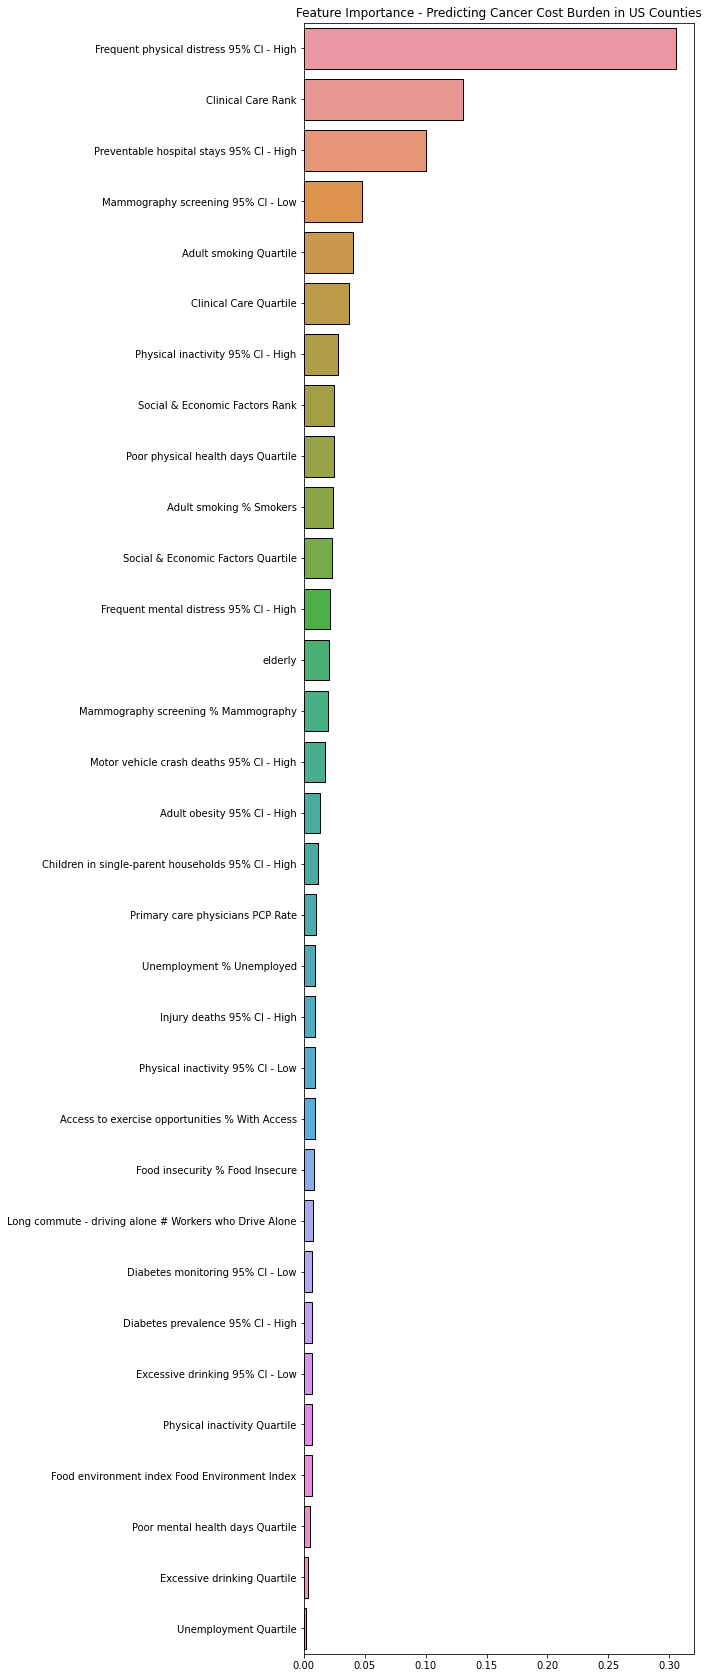

In [21]:
y_pred_train = forest_reg.predict(X_train)
print('R-squared (training set) = ', metrics.r2_score(y_train, y_pred_train))
print('MSE (training set) = ', metrics.mean_squared_error(y_train, y_pred_train))
y_pred = forest_reg.predict(X_test)
print('R-squared (testing set) = ', metrics.r2_score(y_test, y_pred))
print('MSE (testing set) = ', metrics. mean_squared_error(y_test, y_pred))


# Get sorted index of features based on importance (negate so the list is highest to lowest)
ind = np.argsort(-forest_reg.feature_importances_)

fig, ax = plt.subplots(figsize = (7,30))
sns.barplot(x = forest_reg.feature_importances_[ind], y = list(X4.columns[ind]), ax = ax, edgecolor = 'black')
plt.title('Feature Importance - Predicting Cancer Cost Burden in US Counties');
plt.savefig('feature_importance_pred_cancer_cost_burden_randforestreg.png')

---------


# Let's try a similar model, but using GradientBoosting for regression instead of binary classification, to predict the actual cost/income ratio score

In [22]:
from sklearn.ensemble import GradientBoostingRegressor
# Set the X (predictor) and y (target) variables
X5 = X3;

y_gboost = costs_inc_mdl.cancer_cost_inc_ratio   #abv_avg_ca

# Split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X5, y_gboost, random_state = 321, test_size = 0.1)

forest_reg =  GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, max_depth=3, random_state=0, loss='ls')
forest_reg.fit(X_train, y_train)


GradientBoostingRegressor(n_estimators=1000, random_state=0)

## Check the R-squared of the model and plot the feature importance

R-squared (training set) =  0.9888185891184278
MSE (training set) =  0.00011869568385290848
R-squared (testing set) =  0.6565969155216596
MSE (testing set) =  0.003124034578637019


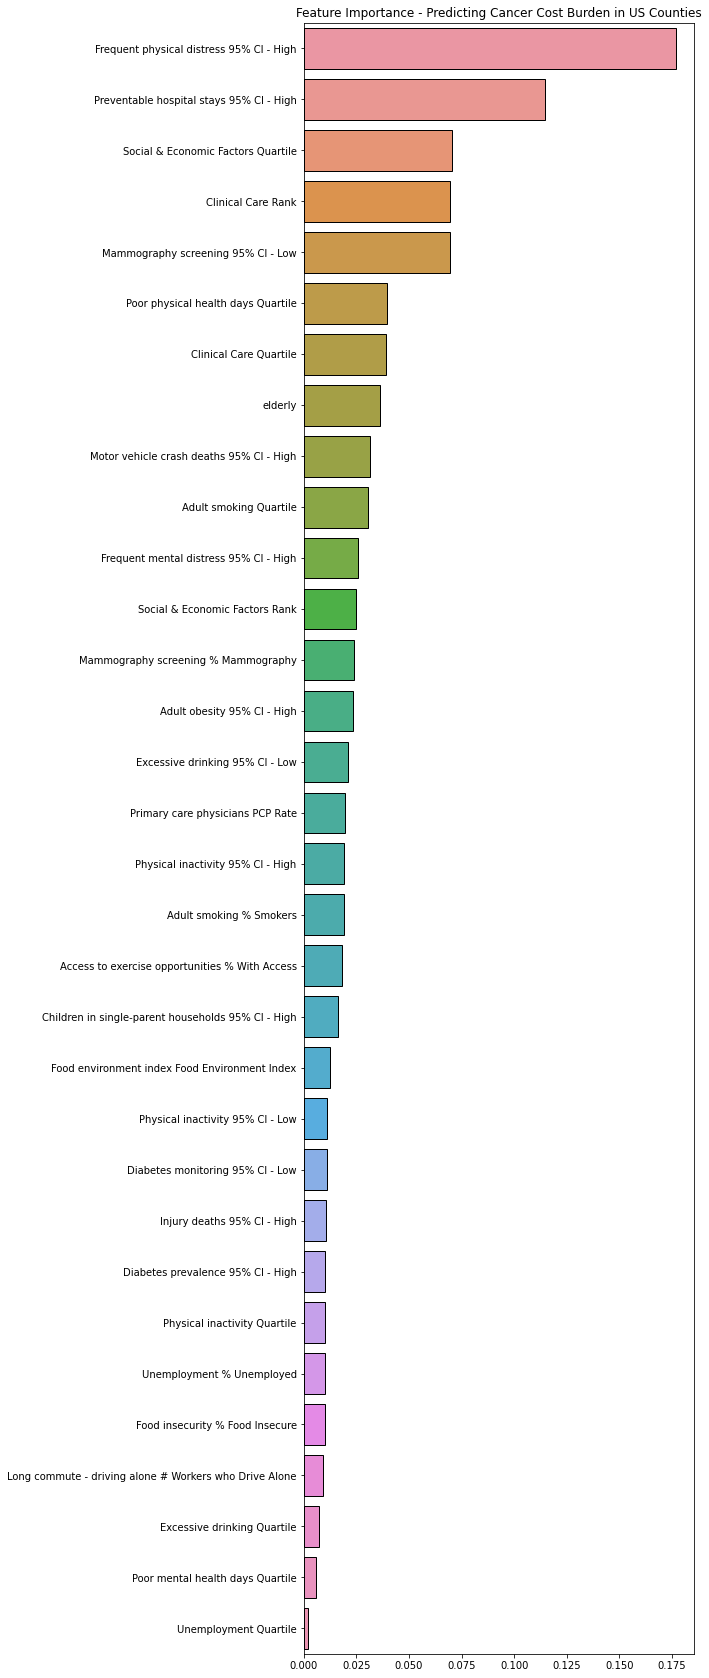

In [23]:
y_pred_train = forest_reg.predict(X_train)
print('R-squared (training set) = ', metrics.r2_score(y_train, y_pred_train))
print('MSE (training set) = ', metrics.mean_squared_error(y_train, y_pred_train))
y_pred = forest_reg.predict(X_test)
print('R-squared (testing set) = ', metrics.r2_score(y_test, y_pred))
print('MSE (testing set) = ', metrics. mean_squared_error(y_test, y_pred))

# Get sorted index of features based on importance (negate so the list is highest to lowest)
ind = np.argsort(-forest_reg.feature_importances_)
fig, ax = plt.subplots(figsize = (7,30))
sns.barplot(x = forest_reg.feature_importances_[ind], y = list(X5.columns[ind]), ax = ax, edgecolor = 'black')
plt.title('Feature Importance - Predicting Cancer Cost Burden in US Counties');
plt.savefig('feature_importance_pred_cancer_cost_burden_gradboostreg.png')

-------
# Run a normal linear regression

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
# Set the X (predictor) and y (target) variables
X5 = X3;

# Standardize features
# the scaler object (model)
scaler = StandardScaler()
# fit and transform the data
X5_scl = scaler.fit_transform(X5) 
X5.iloc[:,:] = X5_scl

y_lin = costs_inc_mdl.cancer_cost_inc_ratio  #abv_avg_ca

# Split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X5, y_lin, random_state = 321, test_size = 0.1)

forest_reg =  LinearRegression()
forest_reg.fit(X_train, y_train)

LinearRegression()

R-squared (training set) =  0.6776163398282009
MSE (training set) =  0.0034222469250423347
R-squared (testing set) =  0.6437720356248813
MSE (testing set) =  0.0032407061231726907


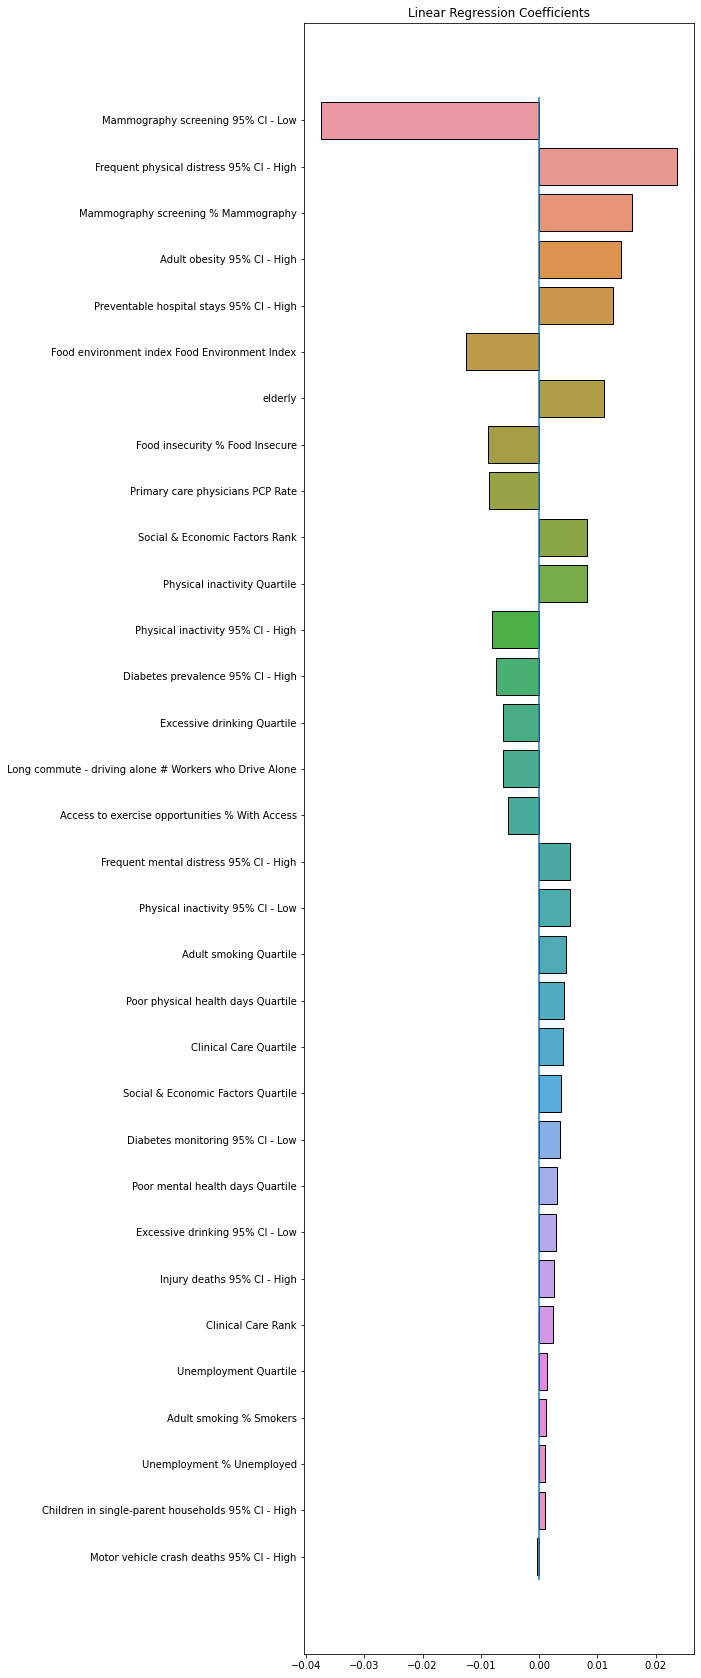

In [25]:
y_pred_train = forest_reg.predict(X_train)
print('R-squared (training set) = ', metrics.r2_score(y_train, y_pred_train))
print('MSE (training set) = ', metrics.mean_squared_error(y_train, y_pred_train))
y_pred = forest_reg.predict(X_test)
print('R-squared (testing set) = ', metrics.r2_score(y_test, y_pred))
print('MSE (testing set) = ', metrics. mean_squared_error(y_test, y_pred))

ind = np.argsort(-abs(forest_reg.coef_))
# Plot the resulting coefficients 
fig, ax = plt.subplots(figsize = (7,30))
sns.barplot(x = forest_reg.coef_[ind], y = list(X5.columns[ind]), ax = ax, edgecolor = 'black')
plt.title('Linear Regression Coefficients')
ymin, ymax = plt.ylim()
plt.vlines(x = 0, ymin = ymin, ymax = ymax);
plt.savefig('feature_importance_pred_cancer_cost_burden_linearreg.png')


-------
# Now let's check how good our predictions are for TN counties

## Load/prepare geopandas data for plotting

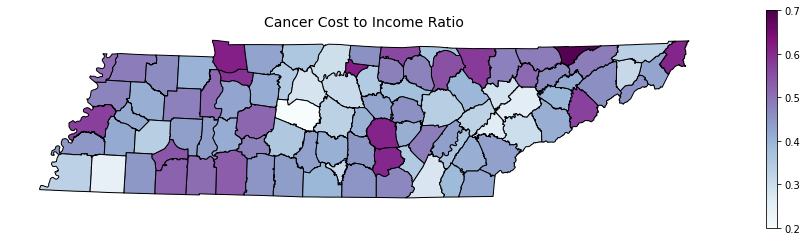

In [26]:
counties = gpd.read_file('../data/county/tncounty.shp')
counties['State'] = 'TN';
# Merge the original dataframe with geopandas data
geo_tn = pd.merge(left = counties, right = cost_income_rank_df, 
                  left_on = ['State','NAME'], right_on = ['State','County'], how = 'inner')

# Plot
fig, ax = plt.subplots(figsize=(16,4))
geo_tn[geo_tn.cancer_cost_inc_ratio.notnull()].plot(column = 'cancer_cost_inc_ratio', 
              cmap = 'BuPu', 
              edgecolor = 'black', 
              legend = True,
              ax = ax,vmin=0.2, vmax=0.7)
plt.title('Cancer Cost to Income Ratio', fontsize = 14)
ax.axis('off');

plt.savefig('cancer_cost_to_inc_ratio_TN_calculated.png')


In [27]:
## Get predictions for only TN counties
# Set the input feature matrix (X) and predicted variable (y)
X_tmp = X5
y_tmp = y_lin
# Get the original dataframe for only TN counties
ci_TN = cost_income_rank_df[cost_income_rank_df.State == 'TN']
# Use index to select the features matrix for TN counties
X_TN = X_tmp[X_tmp.index.isin(ci_TN.index)]
# Get the outcome column based on index
y_TN = y_tmp[y_tmp.index.isin(ci_TN.index)]
# Predict the values of interest based on fitted model
y_pred_TN = forest_reg.predict(X_TN)
print('R-squared (training set) = ', metrics.r2_score(y_TN, y_pred_TN))

R-squared (training set) =  0.6406843069312061


In [28]:
# Combine the model and prediction variables
X_TN['ca_burden_pred'] = y_pred_TN
X_TN['ci_burden'] = y_TN
X_TN_all = X_TN.join(cost_income_rank_df,how='inner',lsuffix='_left', rsuffix='_right')

# Combine with geopandas dataframe
geo_tn_pred = pd.merge(left = counties, right = X_TN_all, 
                  left_on = ['State','NAME'], right_on = ['State','County'], how = 'inner')

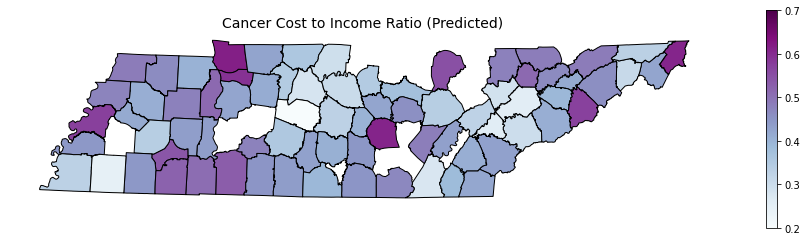

In [29]:
fig, ax = plt.subplots(figsize=(16,4))
geo_tn_pred.plot(column = 'cancer_cost_inc_ratio', 
              cmap = 'BuPu', 
              edgecolor = 'black', 
              legend = True,
              ax = ax, vmin=0.2, vmax=0.7) #[geo_tn_pred.cancer_cost_inc_ratio.notnull()]
plt.title('Cancer Cost to Income Ratio (Predicted) ', fontsize = 14)
ax.axis('off');

plt.savefig('cancer_cost_to_inc_ratio_TN_predicted_randforestreg.png')

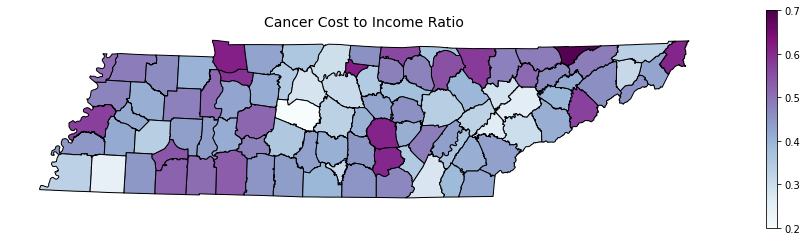

In [30]:
fig, ax = plt.subplots(figsize=(16,4))
geo_tn.plot(column = 'cancer_cost_inc_ratio', 
              cmap = 'BuPu', 
              edgecolor = 'black', 
              legend = True,
              ax = ax, vmin=0.2, vmax=0.7) #[geo_tn.cancer_cost_inc_ratio.notnull()]
plt.title('Cancer Cost to Income Ratio', fontsize = 14)
ax.axis('off');

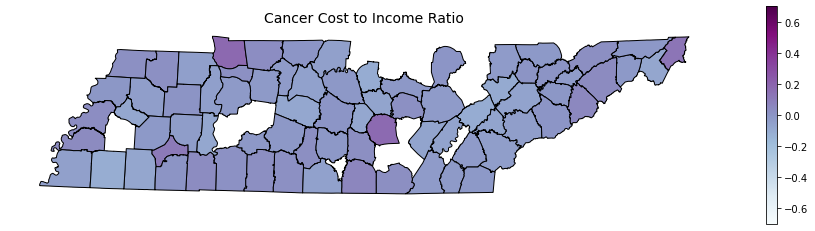

In [31]:
# Plot the difference map
geo_tn_pred['diff_in_pred'] = geo_tn_pred.ci_burden - geo_tn_pred.ca_burden_pred;
fig, ax = plt.subplots(figsize=(16,4))
geo_tn_pred.plot(column = 'diff_in_pred', 
              cmap = 'BuPu', 
              edgecolor = 'black', 
              legend = True,
              ax = ax, vmin=-0.7, vmax=0.7) #[geo_tn.cancer_cost_inc_ratio.notnull()]
plt.title('Cancer Cost to Income Ratio', fontsize = 14)
ax.axis('off');

-------
# Now let's check how good the BINARY predictions are for TN counties

In [32]:
## Get predictions for only TN counties
# Set the input feature matrix (X) and predicted variable (y)
X_tmp = X2
y_tmp = y2
forest_tmp = forest2

# Get the original dataframe for only TN counties
ci_TN = cost_income_rank_df[cost_income_rank_df.State == 'TN']
# Use index to select the features matrix for TN counties
X_TN = X_tmp[X_tmp.index.isin(ci_TN.index)]
# Get the outcome column based on index
y_TN = y_tmp[y_tmp.index.isin(ci_TN.index)]
# Predict the values of interest based on fitted model
y_pred_TN = forest_tmp.predict(X_TN)
print(metrics.accuracy_score(y_TN, y_pred_TN))

0.881578947368421


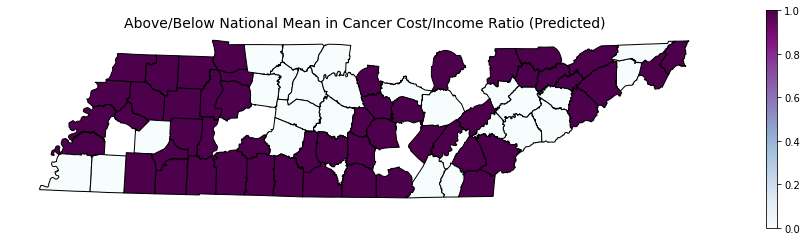

In [33]:
# Combine the model and prediction variables
X_TN['ca_burden_pred'] = y_pred_TN
X_TN['ci_burden'] = y_TN
X_TN_all = X_TN.join(cost_income_rank_df,how='inner',lsuffix='_left', rsuffix='_right')

# Combine with geopandas dataframe
geo_tn_pred = pd.merge(left = counties, right = X_TN_all, 
                  left_on = ['State','NAME'], right_on = ['State','County'], how = 'inner')
fig, ax = plt.subplots(figsize=(16,4))
geo_tn_pred.plot(column = 'ca_burden_pred', 
              cmap = 'BuPu', 
              edgecolor = 'black', 
              legend = True,
              ax = ax, vmin=0, vmax=1) #[geo_tn_pred.cancer_cost_inc_ratio.notnull()]
plt.title('Above/Below National Mean in Cancer Cost/Income Ratio (Predicted)', fontsize = 14)
ax.axis('off');
plt.savefig('abv_below_national_mean_cancer_cost_to_inc_ratio_TN_predicted_randforestcls.png')

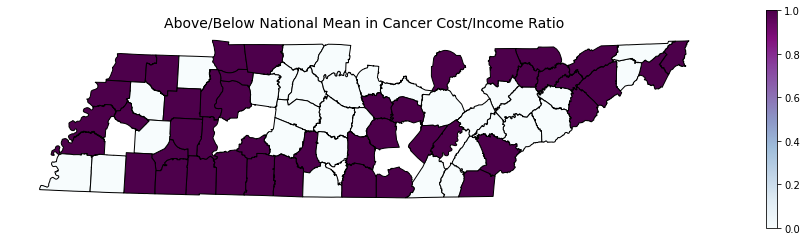

In [34]:
fig, ax = plt.subplots(figsize=(16,4))
geo_tn_pred.plot(column = 'ci_burden', 
              cmap = 'BuPu', 
              edgecolor = 'black', 
              legend = True,
              ax = ax, vmin=0, vmax=1) #[geo_tn_pred.cancer_cost_inc_ratio.notnull()]
plt.title('Above/Below National Mean in Cancer Cost/Income Ratio', fontsize = 14)
ax.axis('off');
plt.savefig('abv_below_national_mean_cancer_cost_to_inc_ratio_TN_randforestcls.png')